In [3]:
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_openai import AzureChatOpenAI
import os


In [4]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

In [13]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_community.utilities import SQLDatabase

credentials

In [6]:
# ✅ Set up Azure OpenAI credentials (Replace with actual values)
os.environ["AZURE_OPENAI_API_KEY"] = "FFET9uLyHtQChg6QazhNMODbWslKvHbEeBRJgpsHtFuf4ybC7xT1JQQJ99AKAC5RqLJXJ3w3AAABACOGBLT0"  
os.environ["AZURE_OPENAI_ENDPOINT"] = 'https://oai-habint-cca-dev-weur.openai.azure.com/'

# ✅ Initialize LLM with Azure OpenAI
llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    openai_api_version="2024-08-01-preview",
    azure_endpoint=os.getenv("https://oai-habint-cca-dev-weur.openai.azure.com/"),
    api_key=os.getenv("FFET9uLyHtQChg6QazhNMODbWslKvHbEeBRJgpsHtFuf4ybC7xT1JQQJ99AKAC5RqLJXJ3w3AAABACOGBLT0"),
)

In [15]:
db = SQLDatabase.from_uri("sqlite:///ecommerce_final.db")
agent_executor = create_sql_agent(llm, db=db)

Functions

In [16]:

#  Define Math Functions
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

In [17]:
# ✅ Define Product Info Function
def product_info(query: str) -> str:
    """Provide product information."""
    return (
        "Available mobile phones and storage capacities: \n"
        "iPhone 15 Pro: 128GB, 256GB, 512GB, 1TB \n"
        "Samsung Galaxy S23 Ultra: 256GB, 512GB, 1TB\n"
        "Google Pixel 8 Pro: 128GB, 256GB, 512GB, 1TB \n" 
        "OnePlus 11: 128GB, 256GB\n"
        "Samsung Galaxy A54: 128GB, 256GB \n"
        "Motorola Moto G Power (2023): 256 GB.")

In [18]:
# from langchain_community.agent_toolkits import create_sql_agent
# from langchain_community.utilities import SQLDatabase

# db = SQLDatabase.from_uri("sqlite:///ecommerce_final.db")
# agent_executor = create_sql_agent(llm, db=db, verbose=True)

# agent_executor.invoke("how many customers are there?")

In [19]:
def sql_agent(query: str):
    """
    This function takes a natural language query,
    passes it to the LLM agent connected to SQLite, and returns the result.
    """
    response = agent_executor.invoke(query)
    return response

React Agents

In [20]:

# ✅ Create Math Agent
math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply],
    name="math_agent",
    prompt="You are a math expert. Always use one tool at a time."
)


In [21]:
# ✅ Create Product Info Agent
product_info_agent = create_react_agent(
    model=llm,
    tools=[product_info],
    name="product_info_agent",
    prompt="You are a product information expert. Do not perform math calculations.")

In [22]:
# ✅ Create Math Agent
sql_agent = create_react_agent(
    model=llm,
    tools=[sql_agent],
    name="sql_agent",
    prompt="You are a SQL expert. Answer the queries based on the database."
)


Members Prompt Router MessagesState

In [24]:
members = ["math_agent", "product_info_agent","sql_agent"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]


In [25]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


In [26]:

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



In [27]:
class State(MessagesState):
    next: str


Supervisor - NODE

In [28]:
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:

    messages = [{"role": "system", "content": system_prompt},] + state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)

    goto = response["next"]

    if goto == "FINISH":
        
        goto = END

    return Command(goto=goto, update={"next": goto})

In [ ]:
# def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
#     result = chart_agent.invoke(state)
#     goto = get_next_node(result["messages"][-1], "researcher")
#     # wrap in a human message, as not all providers allow
#     # AI message at the last position of the input messages list
#     result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
#     return Command(
#         update={
#             # share internal message history of chart agent with other agents
#             "messages": result["messages"],
#         },
#         goto=goto,
#     )

NODES

In [31]:
def math_node(state: State) -> Command[Literal["supervisor"]]:
    result = math_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="math_agent")
            ]
        },
        goto="supervisor",
    )


In [32]:
def product_info_node(state: State) -> Command[Literal["supervisor"]]:
    result = product_info_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="product_info_agent")
            ]
        },
        goto="supervisor",
    )

In [33]:
def sql_node(state: State) -> Command[Literal["supervisor"]]:
    result = sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="sql_agent")
            ]
        },
        goto="supervisor",
    )

Graph

In [34]:
builder = StateGraph(State)
# builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("math_agent", math_node)
builder.add_node("product_info_agent", product_info_node)
builder.add_node("sql_agent", sql_node) 
builder.add_edge(START, "supervisor")

graph = builder.compile()

In [66]:
# builder = StateGraph(State)
# builder.add_edge(START, "supervisor")
# builder.add_node("supervisor", supervisor_node, parallel=True)  # Enable parallel execution
# builder.add_node("math_agent", math_node, parallel=True)
# builder.add_node("product_info_agent", product_info_node, parallel=True)
# graph = builder.compile()


In [35]:

graph = builder.compile()

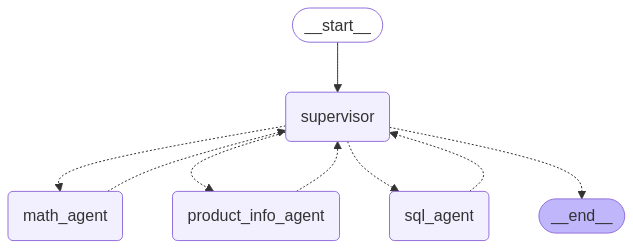

In [36]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

Result

In [38]:
for s in graph.stream(
    {"messages": [("user", "What is the state of orders for customer id 1")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'sql_agent'}})
----
(('sql_agent:0833da63-b66b-06aa-c7ee-748a2e260c0d',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5nsj5VsNT7G1qrJvVBGGMZ79', 'function': {'arguments': '{"query":"SELECT order_id, order_date, status FROM orders WHERE customer_id = 1;"}', 'name': 'sql_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 86, 'total_tokens': 116, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b705f0c291', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': '

In [40]:
# for s in graph.stream(
#     {
#         "messages": [
#             (
#                 "user",
#                 "iphone 15 pro storage options",
#             )
#         ]
#     },
#     subgraphs=True,
# ):
#     print(s)
#     print("----")

In [39]:
# for s in graph.stream(
#     {
#         "messages": [
#             (
#                 "user",
#                 "iphone 15 pro storage options and then multiply 3 by 5",
#             )
#         ]
#     },
#     subgraphs=True,
# ):
#     print(s)
#     print("----")